# Lab2

In [187]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, Optional, List
from collections import defaultdict
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_context("talk")
sns.set_style("whitegrid")

In [188]:
DATA_PATH = "data.csv"
TARGET_CANDIDATES = ["target", "label", "class", "y", "Primary_Concept_of_Publication"]
DEFAULT_TEST_SIZE = 0.2
DEFAULT_RANDOM_STATE = 42
DEFAULT_TOP_K = 50

In [189]:
def load_dataframe(path: str = DATA_PATH) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Не найден файл {path}. Поместите датасет рядом с ноутбуком.")
    df = pd.read_csv(path)
    if df.shape[1] < 2:
        raise ValueError("В датасете недостаточно столбцов.")
    return df

def infer_target_column(df: pd.DataFrame) -> str:
    for c in TARGET_CANDIDATES:
        if c in df.columns:
            return c
    return df.columns[-1]

def binarize_target(y: pd.Series, positive_categories: Optional[List[str]] = None) -> Tuple[np.ndarray, Dict]:
    classes = y.dropna().unique()
    if positive_categories is not None and len(positive_categories) > 0:
        pos_set = set(positive_categories)
        mapping = {c: (1 if c in pos_set else -1) for c in classes}
        y_bin = y.map(mapping).fillna(-1).astype(int).values
        return y_bin, mapping
    if len(classes) <= 1:
        raise ValueError("Только один класс в целевой переменной")
    if len(classes) == 2:
        cls_sorted = list(pd.Series(classes).sort_values().values)
        mapping = {cls_sorted[0]: -1, cls_sorted[1]: 1}
    else:
        most_common = y.value_counts().idxmax()
        mapping = {c: (1 if c == most_common else -1) for c in classes}
    y_bin = y.map(mapping).fillna(-1).astype(int).values
    return y_bin, mapping

def split_train_test(df: pd.DataFrame, target_col: str, test_size: float = DEFAULT_TEST_SIZE, random_state: int = DEFAULT_RANDOM_STATE,
                     positive_categories: Optional[List[str]] = None):
    from sklearn.model_selection import train_test_split
    y_raw = df[target_col]
    X_raw = df.drop(columns=[target_col])
    y, mapping = binarize_target(y_raw, positive_categories=positive_categories)
    X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(X_raw, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_tr_raw, X_te_raw, y_tr, y_te, mapping

def one_hot_encode_fit_transform(X_tr_raw: pd.DataFrame):
    cat_cols = X_tr_raw.select_dtypes(include=["object","category","bool"]).columns.tolist()
    X_tr = pd.get_dummies(X_tr_raw, columns=cat_cols, drop_first=False)
    fitted_columns = X_tr.columns.tolist()
    return X_tr, fitted_columns

def one_hot_encode_transform_like(X_raw: pd.DataFrame, fitted_columns: List[str]):
    cat_cols = X_raw.select_dtypes(include=["object","category","bool"]).columns.tolist()
    X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=False)
    for c in fitted_columns:
        if c not in X.columns:
            X[c] = 0
    X = X[fitted_columns]
    return X

def standardize_fit_transform(X_tr: pd.DataFrame):
    mu = X_tr.mean(axis=0).values
    std = X_tr.std(axis=0, ddof=0).values
    std[std == 0] = 1.0
    X_tr_std = (X_tr.values - mu) / std
    return X_tr_std, mu, std

def standardize_transform(X: pd.DataFrame, mu: np.ndarray, std: np.ndarray):
    std_adj = std.copy()
    std_adj[std_adj == 0] = 1.0
    return (X.values - mu) / std_adj

def select_top_k_by_abs_corr(X_tr_std: np.ndarray, y_tr: np.ndarray, feature_names: List[str], k: int) -> Tuple[np.ndarray, List[int], List[str]]:
    n_feats = X_tr_std.shape[1]
    corrs = np.zeros(n_feats)
    y_centered = y_tr - y_tr.mean()
    y_denom = np.sqrt((y_centered ** 2).sum())
    if y_denom == 0:
        y_denom = 1.0
    for j in range(n_feats):
        x = X_tr_std[:, j]
        x_centered = x - x.mean()
        denom = np.sqrt((x_centered ** 2).sum())
        if denom == 0:
            corrs[j] = 0.0
        else:
            corrs[j] = abs((x_centered * y_centered).sum() / (denom * y_denom))
    k_eff = min(k, n_feats)
    top_idx = np.argsort(-corrs)[:k_eff]
    top_names = [feature_names[i] for i in top_idx]
    return top_idx, top_names, corrs.tolist()

def prepare_data(path: str = DATA_PATH, test_size: float = DEFAULT_TEST_SIZE, random_state: int = DEFAULT_RANDOM_STATE, top_k: int = DEFAULT_TOP_K,
                 positive_categories: Optional[List[str]] = None):
    df = load_dataframe(path)
    target_col = infer_target_column(df)
    X_tr_raw, X_te_raw, y_tr, y_te, mapping = split_train_test(df, target_col, test_size, random_state, positive_categories=positive_categories)
    X_tr_oh, fitted_columns = one_hot_encode_fit_transform(X_tr_raw)
    X_te_oh = one_hot_encode_transform_like(X_te_raw, fitted_columns)
    X_tr_std, mu, std = standardize_fit_transform(X_tr_oh)
    X_te_std = standardize_transform(X_te_oh, mu, std)
    top_idx, top_names, corrs = select_top_k_by_abs_corr(X_tr_std, y_tr, X_tr_oh.columns.tolist(), top_k)
    X_tr_sel = X_tr_std[:, top_idx]
    X_te_sel = X_te_std[:, top_idx]
    return {
        "X_train": X_tr_sel,
        "y_train": y_tr.astype(int),
        "X_test": X_te_sel,
        "y_test": y_te.astype(int),
        "feature_names": top_names,
        "mapping": mapping,
        "all_corrs": corrs,
        "target_col": target_col,
        "fitted_columns": fitted_columns,
        "mu": mu,
        "std": std,
        "top_idx": top_idx,
        "X_train_raw": X_tr_raw,
        "X_test_raw": X_te_raw
    }

In [190]:
def add_intercept(X: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    return np.hstack([np.ones((n,1)), X])
def ridge_closed_form(X: np.ndarray, y: np.ndarray, l2: float = 1.0) -> np.ndarray:
    Xb = add_intercept(X)
    d1 = Xb.shape[1]
    XtX = Xb.T @ Xb
    reg = np.eye(d1)
    reg[0,0] = 0.0
    A = XtX + l2 * reg
    Xty = Xb.T @ y
    w = np.linalg.solve(A, Xty)
    return w
def predict_linear(w: np.ndarray, X: np.ndarray) -> np.ndarray:
    Xb = add_intercept(X)
    return Xb @ w
def predict_class_from_linear(w: np.ndarray, X: np.ndarray) -> np.ndarray:
    s = predict_linear(w, X)
    yhat = np.where(s >= 0, 1, -1)
    return yhat.astype(int)
def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float((y_true == y_pred).mean())
def zero_one_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float((y_true != y_pred).mean())

In [191]:
def soft_threshold(w: np.ndarray, tau: float) -> np.ndarray:
    return np.sign(w) * np.maximum(np.abs(w) - tau, 0.0)
class LinearClassifierGD:
    def __init__(self, loss: str = "hinge", l1: float = 0.0, l2: float = 0.0, lr: float = 0.1, n_iters: int = 1000,
                 random_state: Optional[int] = 42, track_history: bool = True):
        assert loss in ("square","hinge","logistic","exponential")
        self.loss = loss
        self.l1 = float(l1)
        self.l2 = float(l2)
        self.lr = float(lr)
        self.n_iters = int(n_iters)
        self.random_state = random_state
        self.track_history = track_history
        self.w_: Optional[np.ndarray] = None
        self.history_ = defaultdict(list)
    def _add_bias(self, X: np.ndarray) -> np.ndarray:
        n = X.shape[0]
        return np.hstack([np.ones((n,1)), X])
    def _margin(self, W: np.ndarray, Xb: np.ndarray, y: np.ndarray) -> np.ndarray:
        return y * (Xb @ W)
    def _data_loss_and_grad(self, W: np.ndarray, Xb: np.ndarray, y: np.ndarray):
        n = Xb.shape[0]
        m = self._margin(W, Xb, y)
        if self.loss == "square":
            # L = mean((1 - m)^2)
            diff = (1.0 - m)
            data_loss = (diff ** 2).mean()
            # grad = 2 * mean((m - 1) * y * x)
            grad = (2.0 * ((m - 1.0)[:, None] * (y[:, None] * Xb))).mean(axis=0)
        elif self.loss == "hinge":
            # L = mean(max(0, 1 - m))
            mask = (m < 1).astype(float)
            data_loss = np.maximum(0.0, 1.0 - m).mean()
            grad = - ( ( (y*mask)[:, None] * Xb ).mean(axis=0) )
        elif self.loss == "logistic":
            # L = mean(log(1+exp(-m)))
            inv = 1.0 / (1.0 + np.exp(m))
            data_loss = np.log1p(np.exp(-m)).mean()
            grad = - ( ((y*inv)[:, None] * Xb).mean(axis=0) )
        elif self.loss == "exponential":
            # L = mean(exp(-m))
            e = np.exp(-m)
            data_loss = e.mean()
            grad = - ( ((y*e)[:, None] * Xb).mean(axis=0) )
        else:
            raise ValueError("Unknown loss")
        return data_loss, grad
    def fit(self, X: np.ndarray, y: np.ndarray):
        rng = np.random.default_rng(self.random_state)
        Xb = self._add_bias(X)
        d = Xb.shape[1]
        W = np.zeros(d)
        for t in range(self.n_iters):
            data_loss, grad = self._data_loss_and_grad(W, Xb, y)
            l2_grad = np.zeros_like(W)
            l2_grad[1:] = self.l2 * W[1:]
            total_grad = grad + l2_grad
            W = W - self.lr * total_grad
            if self.l1 > 0:
                W[1:] = soft_threshold(W[1:], self.lr * self.l1)
            if self.track_history:
                margin = self._margin(W, Xb, y)
                if self.loss == "square":
                    emp = ((1.0 - margin) ** 2).mean()
                elif self.loss == "hinge":
                    emp = np.maximum(0.0, 1.0 - margin).mean()
                elif self.loss == "logistic":
                    emp = np.log1p(np.exp(-margin)).mean()
                else:
                    emp = np.exp(-margin).mean()
                reg = 0.5 * self.l2 * (W[1:] @ W[1:]) + self.l1 * np.abs(W[1:]).sum()
                y_pred = np.where((Xb @ W) >= 0, 1, -1)
                acc = (y_pred == y).mean()
                self.history_["emp_risk"].append(float(emp))
                self.history_["total_loss"].append(float(emp + reg))
                self.history_["acc_train"].append(float(acc))
        self.w_ = W
        return self
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        Xb = self._add_bias(X)
        return Xb @ self.w_
    def predict(self, X: np.ndarray) -> np.ndarray:
        s = self.decision_function(X)
        return np.where(s >= 0, 1, -1).astype(int)

In [192]:
def moving_average(x: List[float], w: int = 10) -> np.ndarray:
    if w <= 1 or len(x) < 2:
        return np.asarray(x)
    x = np.asarray(x, dtype=float)
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    ma = (cumsum[w:] - cumsum[:-w]) / float(w)
    pad = np.ones(w-1) * ma[0]
    return np.concatenate([pad, ma])
def mean_ci(values: List[float], alpha: float = 0.05) -> Tuple[float, float]:
    arr = np.asarray(values, dtype=float)
    m = arr.mean()
    s = arr.std(ddof=1) if len(arr) > 1 else 0.0
    half = 1.96 * s / math.sqrt(max(1, len(arr)))
    return m, half
def plot_with_ci(xs: List[float], ys_samples: List[List[float]], label: str, color: Optional[str] = None):
    ys_samples = [np.asarray(y) for y in ys_samples]
    ys_stack = np.vstack(ys_samples)
    mean = ys_stack.mean(axis=0)
    std = ys_stack.std(axis=0, ddof=1) if ys_stack.shape[0] > 1 else np.zeros_like(mean)
    half = 1.96 * std / math.sqrt(max(1, ys_stack.shape[0]))
    plt.plot(xs, mean, label=label, color=color)
    plt.fill_between(xs, mean - half, mean + half, alpha=0.2, color=color)
    return mean, half
def evaluate_accuracy(y_true: np.ndarray, scores_or_pred: np.ndarray, use_scores: bool = False) -> float:
    if use_scores:
        y_pred = np.where(scores_or_pred >= 0, 1, -1)
    else:
        y_pred = scores_or_pred
    return accuracy_score(y_true, y_pred)

In [193]:
cfg = {
    "path": DATA_PATH,
    "test_size": 0.2,
    "random_state": 42,
    "top_k": 50,
    "positive_categories": [
        "Computer science",
        "Iterated function"
    ]
}
data = prepare_data(**cfg)
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
feature_names = data["feature_names"]
print(f"Target column: {data['target_col']}")
print("Mapping to ±1:", data["mapping"]) 
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution (±1):", dict(zip(unique, counts)))
print("Top features:", feature_names[:10])

Target column: Primary_Concept_of_Publication
Mapping to ±1: {'Computer science': 1, 'Residual': -1, 'Real-time polymerase chain reaction': -1, 'Thematic analysis': -1, 'Cloning (programming)': -1, 'Random forest': -1, 'False discovery rate': -1, 'Cutoff': -1, 'Alignment-free sequence analysis': -1, 'Term (time)': -1, 'Phaser': -1, 'Regret': -1, 'Statistical power': -1, 'Pseudopotential': -1, 'Systematic review': -1, 'Humanities': -1, 'Theory of planned behavior': -1, 'Restricted maximum likelihood': -1, 'Iterated function': 1, 'Softmax function': -1, 'Psychology': -1, 'Moderation': -1, 'Statistics': -1, 'Plug-in': -1, 'Citation': -1, 'Phylogenetic tree': -1, 'Checklist': -1, 'Software': -1, 'Unobservable': -1, 'Preprocessor': -1, 'Technology acceptance model': -1, 'Artificial intelligence': -1, 'Neuroscience': -1, 'Fuzzy logic': -1, 'Shrinkage': -1, 'Computational biology': -1, 'Repeatability': -1, 'Biology': -1, 'Statistical mechanics': -1, 'Electronic data capture': -1, 'Benchmark (

In [194]:
print("DTYPE X_train:", X_train.dtype, "DTYPE y_train:", y_train.dtype)
ridge_grid = np.logspace(-3, 2, 10)
ridge_results = []
for l2 in ridge_grid:
    w_r = ridge_closed_form(X_train.astype(float), y_train.astype(float), l2=float(l2))
    y_pred_test = predict_class_from_linear(w_r, X_test.astype(float))
    acc = accuracy_score(y_test, y_pred_test)
    ridge_results.append((l2, acc))
best_l2_ridge, best_acc_ridge = max(ridge_results, key=lambda t: t[1])
print(f"Лучший ridge l2={best_l2_ridge:.3g}, test accuracy={best_acc_ridge:.4f}")

DTYPE X_train: float64 DTYPE y_train: int32
Лучший ridge l2=0.001, test accuracy=0.8200


Лучшие параметры GD: {'loss': 'hinge', 'l1': 0.001, 'l2': 0.0, 'lr': 0.1, 'n_iters': 400} test acc= 0.82


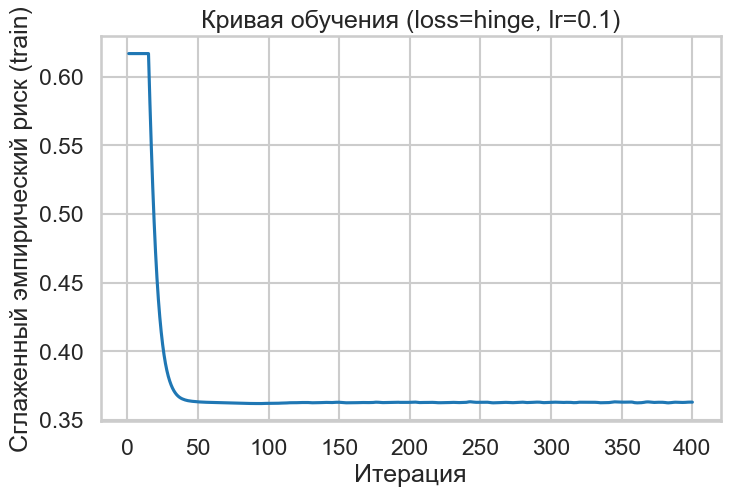

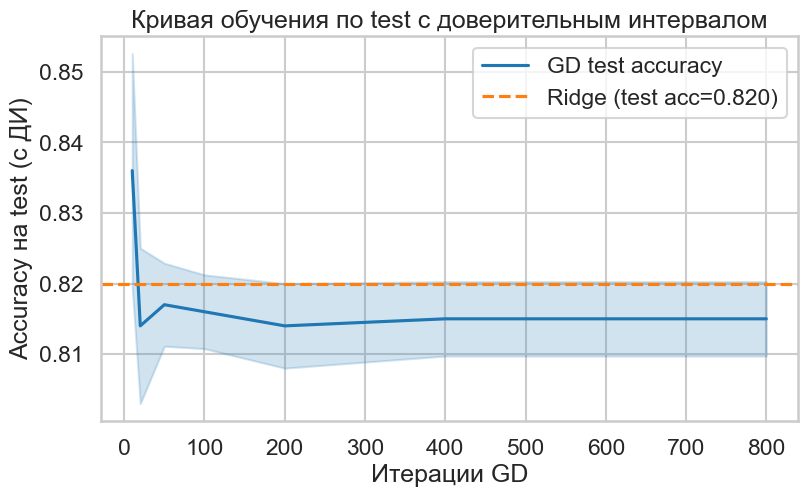

In [ ]:
from itertools import product
gd_param_grid = {
    "loss": ["logistic", "hinge", "exponential"],
    "l1": [0.0, 1e-4, 1e-3],
    "l2": [0.0, 1e-4, 1e-3],
    "lr": [0.05, 0.1, 0.2],
    "n_iters": [400]
}
def grid_search_gd(X_tr, y_tr, X_te, y_te, grid: Dict) -> Dict:
    X_tr = X_tr.astype(float); X_te = X_te.astype(float)
    y_tr = y_tr.astype(int); y_te = y_te.astype(int)
    best = {"score": -np.inf, "params": None}
    for loss, l1, l2, lr in product(grid["loss"], grid["l1"], grid["l2"], grid["lr"]):
        if l1>0 and l2>0:
            continue
        clf = LinearClassifierGD(loss=loss, l1=l1, l2=l2, lr=lr, n_iters=grid["n_iters"][0], track_history=False)
        clf.fit(X_tr, y_tr)
        acc = accuracy_score(y_te, clf.predict(X_te))
        if acc > best["score"]:
            best = {"score": acc, "params": {"loss": loss, "l1": l1, "l2": l2, "lr": lr, "n_iters": grid["n_iters"][0]}}
    return best
best_gd = grid_search_gd(X_train, y_train, X_test, y_test, gd_param_grid)
print("Лучшие параметры GD:", best_gd["params"], "test acc=", round(best_gd["score"],4))
best_params = best_gd["params"].copy()
best_params["n_iters"] = 400 
clf_best = LinearClassifierGD(**best_params, track_history=True)
clf_best.fit(X_train.astype(float), y_train.astype(int))
emp = moving_average(clf_best.history_["emp_risk"], w=15)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(emp)+1), emp)
plt.xlabel("Итерация")
plt.ylabel("Сглаженный эмпирический риск (train)")
plt.title(f"Кривая обучения (loss={best_params['loss']}, lr={best_params['lr']})")
plt.show()

checkpoints = [10, 20, 50, 100, 200, 400]
n_splits = 10
ys_samples = []
for seed in range(100, 100 + n_splits):
    dsplit = prepare_data(path=DATA_PATH, test_size=0.2, random_state=seed, top_k=cfg["top_k"])
    Xt, yt = dsplit["X_train"].astype(float), dsplit["y_train"].astype(int)
    Xv, yv = dsplit["X_test"].astype(float), dsplit["y_test"].astype(int)
    accs = []
    for it in checkpoints:
        p = best_params.copy()
        p["n_iters"] = it
        clf_tmp = LinearClassifierGD(**p, track_history=False, random_state=seed)
        clf_tmp.fit(Xt, yt)
        accs.append(accuracy_score(yv, clf_tmp.predict(Xv)))
    ys_samples.append(accs)
plt.figure(figsize=(9,5))
mean, half = plot_with_ci(checkpoints, ys_samples, label="GD test accuracy", color="tab:blue")
plt.axhline(best_acc_ridge, color="tab:orange", linestyle="--", label=f"Ridge (test acc={best_acc_ridge:.3f})")
plt.xlabel("Итерации GD")
plt.ylabel("Accuracy на test (с ДИ)")
plt.title("Кривая обучения по test с доверительным интервалом")
plt.legend()
plt.show()

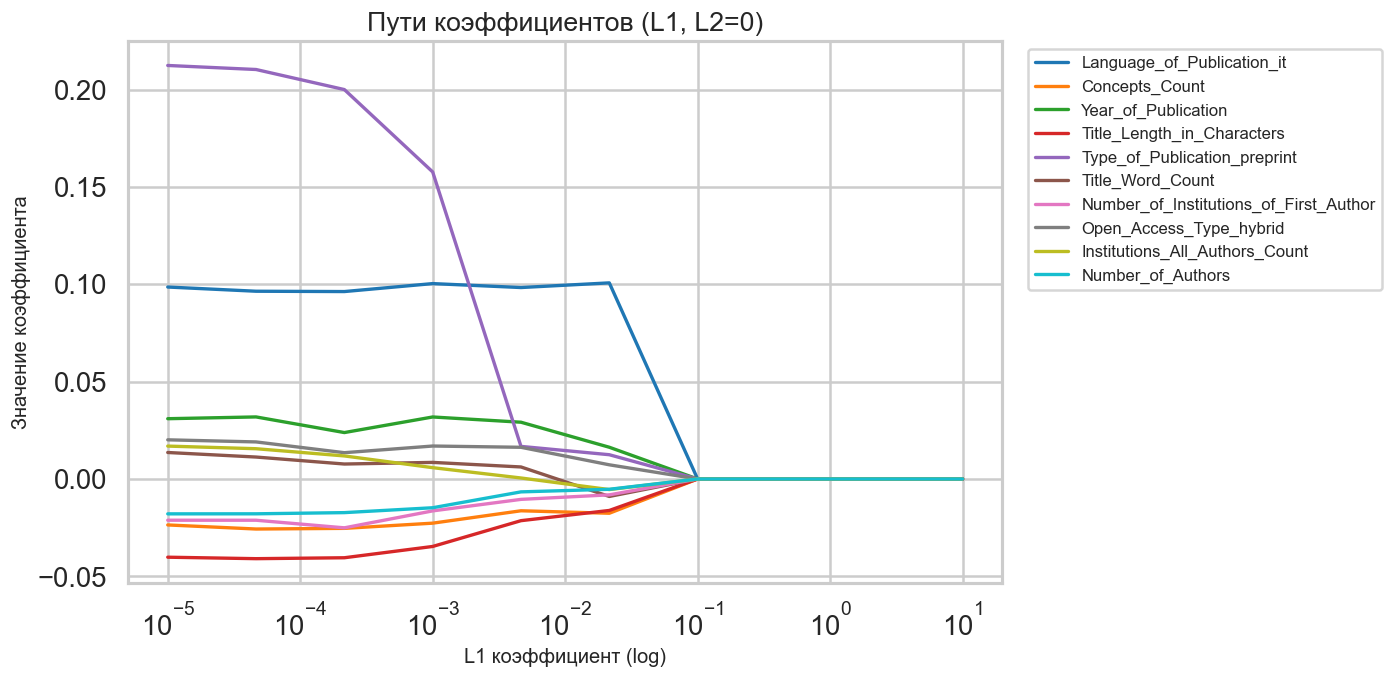

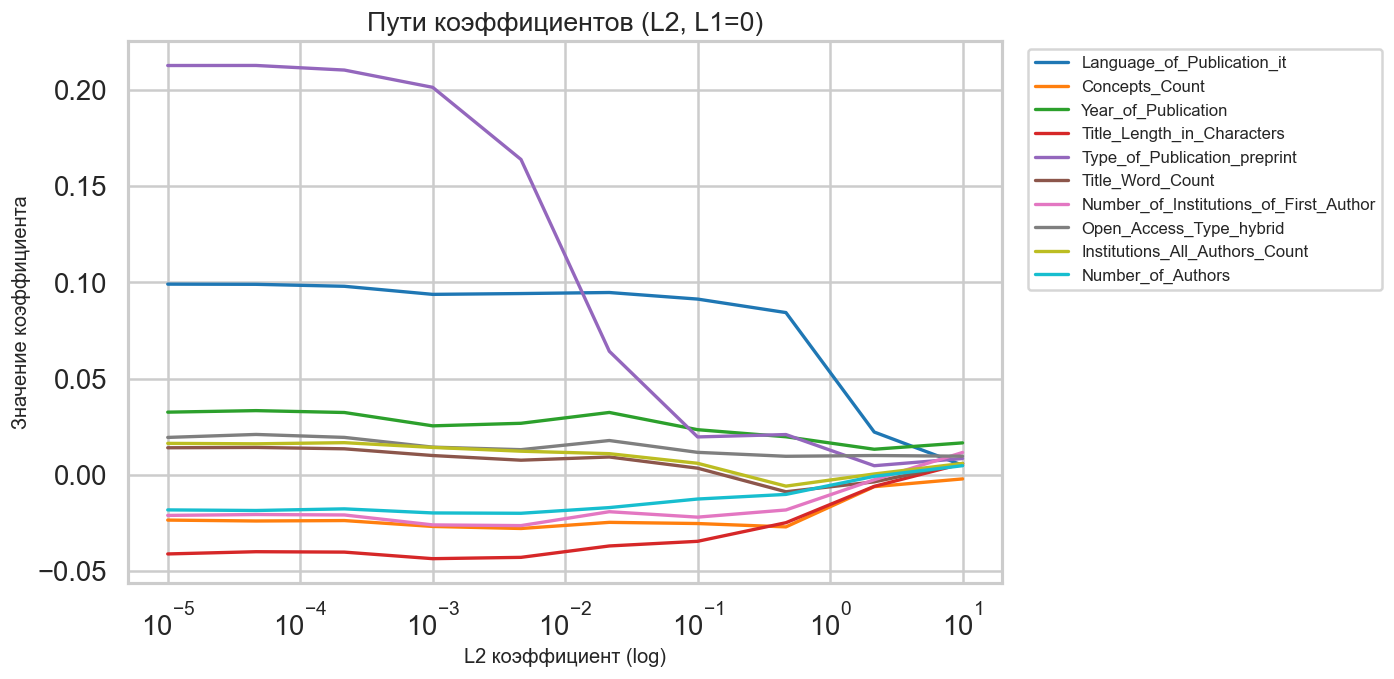

In [196]:
def coefficient_paths(X: np.ndarray, y: np.ndarray, feature_names: List[str], base_loss: str, lr: float, n_iters: int = 500,
                        l1_grid=None, l2_grid=None, top_show: int = 10):
    X = X.astype(float)
    y = y.astype(int)
    if l1_grid is None:
        l1_grid = np.logspace(-5, 1, 10)
    if l2_grid is None:
        l2_grid = np.logspace(-5, 1, 10)
    coefs_l1 = []
    for lam in l1_grid:
        clf = LinearClassifierGD(loss=base_loss, l1=float(lam), l2=0.0, lr=lr, n_iters=n_iters, track_history=False)
        clf.fit(X, y)
        coefs_l1.append(clf.w_[1:].copy())
    coefs_l1 = np.vstack(coefs_l1)
    mid_idx = len(l1_grid)//2
    top_idx = np.argsort(-np.abs(coefs_l1[mid_idx]))[:min(top_show, coefs_l1.shape[1])]
    top_names = [feature_names[i] for i in top_idx]
    coefs_l2 = []
    for lam in l2_grid:
        clf = LinearClassifierGD(loss=base_loss, l1=0.0, l2=float(lam), lr=lr, n_iters=n_iters, track_history=False)
        clf.fit(X, y)
        coefs_l2.append(clf.w_[1:].copy())
    coefs_l2 = np.vstack(coefs_l2)
    return {
        "l1_grid": l1_grid,
        "l2_grid": l2_grid,
        "coefs_l1": coefs_l1[:, top_idx],
        "coefs_l2": coefs_l2[:, top_idx],
        "top_idx": top_idx,
        "top_names": top_names
    }

paths = coefficient_paths(X_train, y_train, feature_names, base_loss=best_params["loss"], lr=best_params["lr"], n_iters=600, top_show=10)

plt.figure(figsize=(12,6), dpi=120)
for j, name in enumerate(paths["top_names"]):
    plt.plot(paths["l1_grid"], paths["coefs_l1"][:, j], label=name, linewidth=2)
plt.xscale('log')
plt.xlabel('L1 коэффициент (log)', fontsize=12)
plt.ylabel('Значение коэффициента', fontsize=12)
plt.title('Пути коэффициентов (L1, L2=0)', fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6), dpi=120)
for j, name in enumerate(paths["top_names"]):
    plt.plot(paths["l2_grid"], paths["coefs_l2"][:, j], label=name, linewidth=2)
plt.xscale('log')
plt.xlabel('L2 коэффициент (log)', fontsize=12)
plt.ylabel('Значение коэффициента', fontsize=12)
plt.title('Пути коэффициентов (L2, L1=0)', fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()